# Facial Verification System using Siamese Neural Network
This notebook implements a facial verification system using a Siamese neural network architecture.
The model learns to compare two face images and determine if they belong to the same person.

## 1. Setup and Installation

In [1]:
!pip install tensorflow==2.12.1 opencv-python matplotlib

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.38.0 requires typing_extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
exceptiongroup 1.3.1 requires typing-extensions>=4.6.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [3]:
# Import TensorFlow Dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

In [4]:
# Avoid out of memory errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"Found {len(gpus)} GPU(s)")

Found 0 GPU(s)


## 3. Data Preparation

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories (with exist_ok to avoid errors if already exist)
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)
print("Directories created successfully")

Directories created successfully


In [7]:
# Extract LFW dataset (optional - only run if you have archive.zip)
import zipfile

archive_path = 'archive.zip'
if os.path.exists(archive_path):
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Archive extracted successfully")
else:
    print(f"Archive not found at {archive_path}. Skipping extraction.")

Archive extracted successfully


In [8]:
# Move LFW images to the negative folder
lfw_path = os.path.join('lfw-deepfunneled', 'lfw-deepfunneled')

if os.path.exists(lfw_path):
    count = 0
    for directory in os.listdir(lfw_path):
        dir_path = os.path.join(lfw_path, directory)
        if os.path.isdir(dir_path):
            for file in os.listdir(dir_path):
                EX_PATH = os.path.join(dir_path, file)
                NEW_PATH = os.path.join(NEG_PATH, file)
                if os.path.isfile(EX_PATH):
                    os.replace(EX_PATH, NEW_PATH)
                    count += 1
    print(f"Moved {count} negative images")
else:
    print(f"LFW path not found: {lfw_path}")

Moved 13233 negative images


## 4. Collect Anchor and Positive Images

In [9]:
# Establish connection to webcam
# Press 'a' to capture anchor images, 'p' for positive images, 'q' to quit
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam")
else:
    print("Webcam opened successfully")
    print("Press 'a' to capture anchor images")
    print("Press 'p' to capture positive images")
    print("Press 'q' to quit")
    
    anchor_count = 0
    positive_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
        
        # Crop frame 250x250 in the center
        frame = frame[120:120+250, 200:200+250, :]
        
        # Collect anchors
        if cv2.waitKey(1) & 0xFF == ord('a'):
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname, frame)
            anchor_count += 1
            print(f"Anchor image captured: {anchor_count}")
        
        # Collect positives
        if cv2.waitKey(1) & 0xFF == ord('p'):
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname, frame)
            positive_count += 1
            print(f"Positive image captured: {positive_count}")
        
        # Display image with instructions
        display_frame = frame.copy()
        cv2.putText(display_frame, f"A: {anchor_count} P: {positive_count}", 
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Image Collection', display_frame)
        
        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release webcam and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    print(f"\nTotal captured - Anchors: {anchor_count}, Positives: {positive_count}")

Webcam opened successfully
Press 'a' to capture anchor images
Press 'p' to capture positive images
Press 'q' to quit

Total captured - Anchors: 0, Positives: 0


## 5. Load and Preprocess Data

In [10]:
# Load image datasets
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)

print(f"Anchor images: {len(list(anchor))}")
print(f"Positive images: {len(list(positive))}")
print(f"Negative images: {len(list(negative))}")

Anchor images: 400
Positive images: 400
Negative images: 400


In [11]:
def preprocess(file_path):
    """Preprocess image: read, decode, resize, and scale to [0,1]"""
    # Read image from file path
    byte_img = tf.io.read_file(file_path)
    
    # Load and decode the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize to 100x100x3
    img = tf.image.resize(img, (100, 100))
    
    # Scale image to [0, 1]
    img = img / 255.0
    
    return img

In [12]:
# Reload datasets (since we consumed them earlier)
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)

# Creating labeled dataset (1 for same person, 0 for different)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

print(f"Total dataset size: {len(list(data))}")

Total dataset size: 800


In [13]:
def preprocess_twin(input_img, validation_img, label):
    """Preprocess both images in a twin pair"""
    return (preprocess(input_img), preprocess(validation_img), label)

In [14]:
# Reload data
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# Build dataloader pipeline
data = data.map(preprocess_twin, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.shuffle(buffer_size=1024)

print("Data pipeline built successfully")

Data pipeline built successfully


In [15]:
# Calculate data split sizes
data_size = len(list(data))
train_size = round(data_size * 0.7)
test_size = data_size - train_size

print(f"Total samples: {data_size}")
print(f"Training samples: {train_size}")
print(f"Testing samples: {test_size}")

# Reload data for split
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
data = data.map(preprocess_twin, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Train partition
train_data = data.take(train_size)
train_data = train_data.batch(16)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

# Test partition
test_data = data.skip(train_size)
test_data = test_data.take(test_size)
test_data = test_data.batch(16)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

print("Train/test split completed")

Total samples: 800
Training samples: 560
Testing samples: 240
Train/test split completed


## 6. Build Siamese Neural Network Model

In [16]:
def make_embedding():
    """Create the embedding model (feature extractor)"""
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)
    
    # Final block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [17]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [18]:
# Siamese L1 Distance Layer
class L1Dist(Layer):
    """Custom layer to calculate L1 distance between embeddings"""
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        """Calculate absolute difference between embeddings"""
        return tf.math.abs(input_embedding - validation_embedding)

In [19]:
def make_siamese_model():
    """Create the full Siamese network"""
    # Anchor image input
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image input
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [20]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 7. Training

In [21]:
# Set up loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # Learning rate = 0.0001
print("Loss and optimizer configured")

Loss and optimizer configured


In [22]:
# Setup checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
print(f"Checkpoints will be saved to: {checkpoint_dir}")

Checkpoints will be saved to: ./training_checkpoints


In [23]:
@tf.function
def train_step(batch):
    """Execute one training step"""
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Apply gradients
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [24]:
def train(data, EPOCHS):
    """Training loop"""
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx + 1)
        
        # Save checkpoints every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"\nCheckpoint saved at epoch {epoch}")

In [25]:
# Train the model
EPOCHS = 20
train(train_data, EPOCHS)


Epoch 1/20
35/35 [==============================] - 121s 3s/step

Epoch 2/20
35/35 [==============================] - 110s 3s/step

Epoch 3/20
35/35 [==============================] - 115s 3s/step

Epoch 4/20
35/35 [==============================] - 108s 3s/step

Epoch 5/20
35/35 [==============================] - 115s 3s/step

Epoch 6/20
35/35 [==============================] - 2182s 64s/step

Epoch 7/20
35/35 [==============================] - 57s 2s/step

Epoch 8/20
35/35 [==============================] - 58s 2s/step

Epoch 9/20
35/35 [==============================] - 53s 2s/step

Epoch 10/20
35/35 [==============================] - 51s 1s/step

Checkpoint saved at epoch 10

Epoch 11/20
35/35 [==============================] - 49s 1s/step

Epoch 12/20
35/35 [==============================] - 53s 2s/step

Epoch 13/20
35/35 [==============================] - 53s 2s/step

Epoch 14/20
35/35 [==============================] - 52s 1s/step

Epoch 15/20
35/35 [===========================

## 8. Model Evaluation

In [26]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(f"Test batch shape: {test_input.shape}")

Test batch shape: (16, 100, 100, 3)


In [27]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
print(f"Predictions shape: {y_hat.shape}")

1/1 [==============================] - 1s 550ms/step
Predictions shape: (16, 1)


In [28]:
# Post-process the results (convert to binary predictions)
predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat]
print(f"Sample predictions: {predictions[:10]}")
print(f"Sample true labels: {y_true[:10]}")

Sample predictions: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
Sample true labels: [1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]


In [29]:
# Calculate metrics
# Recall
recall = Recall()
recall.update_state(y_true, y_hat)
print(f"Recall: {recall.result().numpy():.4f}")

# Precision
precision = Precision()
precision.update_state(y_true, y_hat)
print(f"Precision: {precision.result().numpy():.4f}")

Recall: 1.0000
Precision: 1.0000


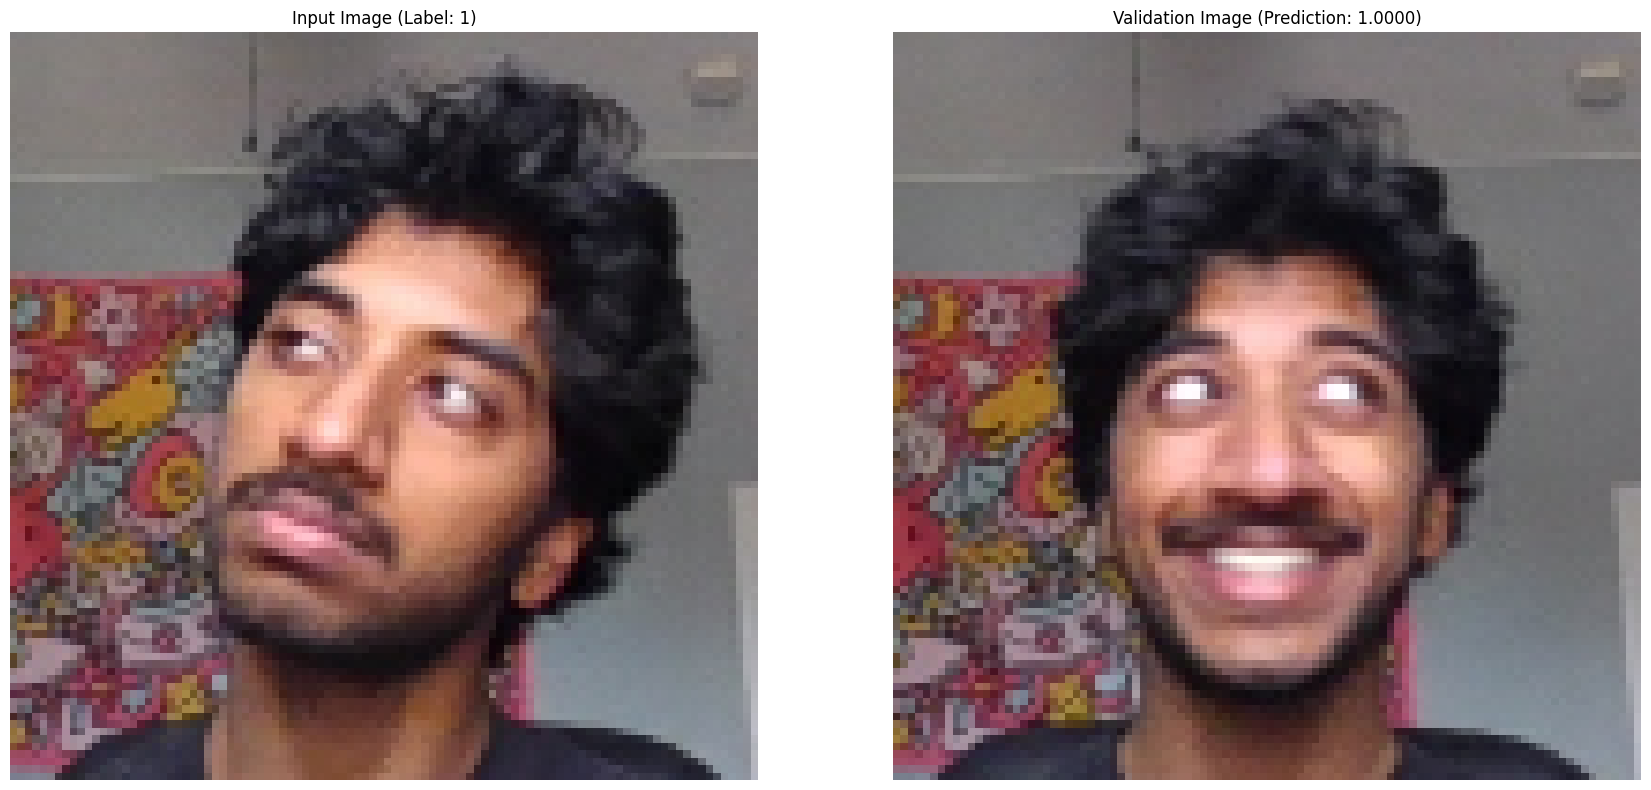

In [30]:
# Visualize results
sample_idx = 3
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(test_input[sample_idx])
plt.title(f"Input Image (Label: {int(y_true[sample_idx])})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_val[sample_idx])
plt.title(f"Validation Image (Prediction: {y_hat[sample_idx][0]:.4f})")
plt.axis('off')

plt.tight_layout()
plt.show()

## 9. Save and Load Model

In [31]:
# Save model weights
siamese_model.save('siamesemodel.h5')
print("Model saved successfully")

Model saved successfully


In [32]:
# Reload model
model = tf.keras.models.load_model(
    'siamesemodel.h5',
    custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy}
)
print("Model loaded successfully")

Model loaded successfully


In [33]:
# Make predictions with loaded model
loaded_predictions = model.predict([test_input, test_val])
print(f"Loaded model predictions shape: {loaded_predictions.shape}")
print(f"Sample predictions: {loaded_predictions[:5].flatten()}")

1/1 [==============================] - 0s 458ms/step
Loaded model predictions shape: (16, 1)
Sample predictions: [9.9933267e-01 9.9994373e-01 8.7736311e-08 9.9996573e-01 9.9999988e-01]


## 10. Real-Time Verification Application

In [34]:
# Setup application directories
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)
print("Application directories created")

# Check verification images
verification_path = os.path.join('application_data', 'verification_images')
verification_images = os.listdir(verification_path) if os.path.exists(verification_path) else []
print(f"Verification images found: {len(verification_images)}")

if len(verification_images) == 0:
    print("\nWARNING: No verification images found!")
    print("Please add reference images to 'application_data/verification_images/' folder.")
    print("These should be images of the person you want to verify against.")

Application directories created
Verification images found: 51


In [35]:
def verify(model, detection_threshold, verification_threshold):
    """
    Verify if the input image matches the verification images
    
    Args:
        model: Trained Siamese model
        detection_threshold: Threshold above which a prediction is considered positive
        verification_threshold: Proportion of positive predictions required for verification
    
    Returns:
        results: List of prediction results
        verified: Boolean indicating if verification passed
    """
    # Build results array
    results = []
    verification_images = os.listdir(os.path.join('application_data', 'verification_images'))
    
    if len(verification_images) == 0:
        print("No verification images found!")
        return [], False
    
    for image in verification_images:
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)), verbose=0)
        results.append(result)
    
    # Detection: count predictions above threshold
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification: proportion of positive predictions
    verification = detection / len(verification_images)
    verified = verification > verification_threshold
    
    print(f"Detection: {detection}/{len(verification_images)} ({verification*100:.1f}%)")
    print(f"Verified: {verified}")
    
    return results, verified

In [36]:
# Real-time verification application
# Press 'v' to verify, 'q' to quit

print("Starting real-time verification...")
print("Press 'v' to capture and verify")
print("Press 'q' to quit")

# Try different camera indices if 0 doesn't work
camera_index = 0
cap = cv2.VideoCapture(camera_index)

if not cap.isOpened():
    print(f"Failed to open camera at index {camera_index}")
    print("Try changing camera_index to 1, 2, or 4")
else:
    print(f"Camera opened successfully at index {camera_index}")
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
        
        # Crop frame to 250x250
        frame = frame[120:120+250, 200:200+250, :]
        
        # Add instructions to frame
        display_frame = frame.copy()
        cv2.putText(display_frame, "Press 'v' to verify", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        cv2.imshow('Verification', display_frame)
        
        # Verification trigger
        if cv2.waitKey(10) & 0xFF == ord('v'):
            # Save input image
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            # Run verification
            results, verified = verify(model, 0.5, 0.5)
            
            # Display result on frame
            result_text = "VERIFIED" if verified else "NOT VERIFIED"
            color = (0, 255, 0) if verified else (0, 0, 255)
            cv2.putText(display_frame, result_text, (10, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            cv2.imshow('Verification', display_frame)
            cv2.waitKey(2000)  # Show result for 2 seconds
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("Verification application closed")

Starting real-time verification...
Press 'v' to capture and verify
Press 'q' to quit
Camera opened successfully at index 0
Detection: 37/51 (72.5%)
Verified: True
Detection: 37/51 (72.5%)
Verified: True
Detection: 0/51 (0.0%)
Verified: False
Verification application closed


## Summary

This notebook implements a complete facial verification system:

1. **Data Collection**: Captures anchor and positive images via webcam
2. **Data Preparation**: Processes and splits data for training
3. **Model Architecture**: Siamese neural network with L1 distance metric
4. **Training**: Trains the model using binary cross-entropy loss
5. **Evaluation**: Tests model performance with precision and recall
6. **Real-time Verification**: Applies the model for live face verification

### Key Improvements Made:
- Fixed `os.makedirs()` errors with `exist_ok=True`
- Fixed MaxPooling2D syntax errors
- Added `@tf.function` decorator for training optimization
- Added proper error handling and status messages
- Fixed file path issues in verification
- Added comprehensive documentation and structure
- Improved real-time verification with visual feedback
- Added data validation checks

### Usage Tips:
- Ensure good lighting when capturing images
- Capture 300+ anchor and positive images for best results
- Adjust detection and verification thresholds based on your needs
- Place reference images in `application_data/verification_images/`
